<a href="https://colab.research.google.com/github/hurtadosanti/TrafficSignClassifier/blob/master/TrafficSignClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Traffic Sign Recognition Classifier
Self-Driving Car Engineer Nanodegree

Deep Learning

<a href="https://colab.research.google.com/github/hurtadosanti/TrafficSignClassifier/blob/master/TrafficSignClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## Import packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from random import randint
import pickle
import os
from zipfile import ZipFile
from sklearn.utils import shuffle
from skimage import data, color
from skimage.transform import rotate, rescale
from skimage.util import random_noise

%tensorflow_version 1.x

import tensorflow as tf
from tensorflow.contrib.layers import flatten

%matplotlib inline


TensorFlow 1.x selected.


## Load Data

In [2]:
path = '/tmp/'
traffic_signs_file = 'traffic-signs-data.zip'
!wget --no-check-certificate \
    https://s3-us-west-1.amazonaws.com/udacity-selfdrivingcar/traffic-signs-data.zip \
    -O /tmp/traffic-signs-data.zip

!wget --no-check-certificate \
    https://raw.githubusercontent.com/udacity/CarND-Traffic-Sign-Classifier-Project/master/signnames.csv

with ZipFile(path+traffic_signs_file, 'r') as zipObj:
   zipObj.extractall(path)
   print('Finish extracting')

--2020-09-24 14:35:52--  https://s3-us-west-1.amazonaws.com/udacity-selfdrivingcar/traffic-signs-data.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.120.16
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.120.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 123524425 (118M) [application/zip]
Saving to: ‘/tmp/traffic-signs-data.zip’

/tmp/traffic-signs- 100%[===================>] 117.80M  20.7MB/s    in 6.5s    

2020-09-24 14:35:59 (18.0 MB/s) - ‘/tmp/traffic-signs-data.zip’ saved [123524425/123524425]

--2020-09-24 14:35:59--  https://raw.githubusercontent.com/udacity/CarND-Traffic-Sign-Classifier-Project/master/signnames.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9

In [3]:
train = pickle.load(open(path+"train.p", 'rb'))
valid=pickle.load(open(path+"valid.p", 'rb'))
test = pickle.load(open(path+"test.p", 'rb'))
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']
# Verify that the data is complete
assert(len(X_train)==len(y_train))
assert(len(X_valid)==len(y_valid))
assert(len(X_test)==len(y_test))

## Data Summary and exploration

In [4]:
# Data Size
print('Training set samples:\t',len(X_train))
print('Validation set samples:\t',len(X_valid))
print('Test set samples:\t',len(X_test))
# Sign names labels
sign_names = pd.read_csv('signnames.csv')
print(sign_names.head())
print(sign_names.describe())

Training set samples:	 34799
Validation set samples:	 4410
Test set samples:	 12630
   ClassId              SignName
0        0  Speed limit (20km/h)
1        1  Speed limit (30km/h)
2        2  Speed limit (50km/h)
3        3  Speed limit (60km/h)
4        4  Speed limit (70km/h)
         ClassId
count  43.000000
mean   21.000000
std    12.556539
min     0.000000
25%    10.500000
50%    21.000000
75%    31.500000
max    42.000000


### Random Samples

In [5]:
# Random signs from the Y data
results = list(np.random.permutation(np.arange(0,y_test.shape[0])))
for i in results[:10]:
    sign_index = y_train[i]
    print(i,sign_index,sign_names.at[sign_index,'SignName'])

7968 4 Speed limit (70km/h)
9358 11 Right-of-way at the next intersection
4105 1 Speed limit (30km/h)
5952 3 Speed limit (60km/h)
5711 3 Speed limit (60km/h)
2373 1 Speed limit (30km/h)
7851 4 Speed limit (70km/h)
5546 3 Speed limit (60km/h)
2548 1 Speed limit (30km/h)
3604 1 Speed limit (30km/h)


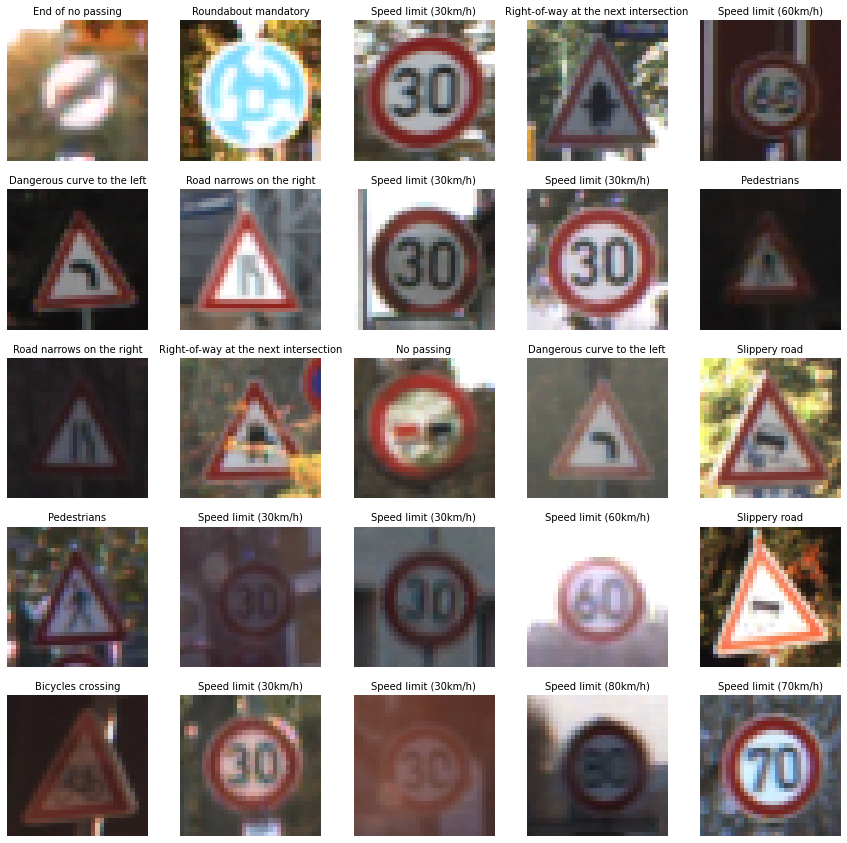

In [6]:
# Random signs images and the correspondent name
fig, axes = plt.subplots(5,5, figsize=(15,15))
results = list(np.random.permutation(np.arange(0,y_test.shape[0])))
for i,ax in  enumerate(axes.flat):
    pos = results[i]
    sign_index = y_train[pos]
    ax.set_title(sign_names.at[sign_index,'SignName'],fontsize=10)
    ax.imshow(X_train[pos])
    ax.set_axis_off()

## Data distribution

                  0
count  12630.000000
mean      15.551069
std       11.947123
min        0.000000
25%        5.000000
50%       12.000000
75%       25.000000
max       42.000000


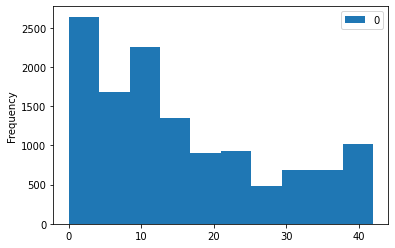

In [7]:
# Describe test Y data
df_y_test = pd.DataFrame(y_test)
print(df_y_test.describe())
df_y_test.plot.hist()

## Data preprocessing

In [8]:
def convert_gray(images):
    gray = []
    for i,img in enumerate(images):
        gray_image = color.rgb2grey(img)
        new_row = np.reshape(gray_image,gray_image.shape+(1,))
        gray.append(new_row)
    result = np.array(gray)
    del gray
    return result

def augment_data_set(images,labels,angle):
    augmented_list = []
    label_list = []
    for i,img in enumerate(images):
      augmented_list.append(rotate(img,angle))
      augmented_list.append(rotate(img,angle*-1))
      augmented_list.append(random_noise(img))
      label_list.append(labels[i])
      label_list.append(labels[i])
      label_list.append(labels[i])
    res_rotated = np.array(augmented_list)
    res_label = np.array(label_list)
    del augmented_list
    del label_list
    return res_rotated,res_label

In [9]:
X_train_normalized = X_train/255.0
X_valid_normalized = X_valid/255.0
#X_train_gray = np.sum(X_train_normalized/3, axis=3, keepdims=True)
X_train_gray = convert_gray(X_train_normalized)
X_valid_gray = convert_gray(X_valid_normalized)
#X_valid_gray = np.sum(X_valid_normalized/3, axis=3, keepdims=True)

In [12]:
augmented_images,augmented_labels = augment_data_set(X_train_gray,y_train,15)
print('augmented data',augmented_images.shape,augmented_labels.shape)
assert len(augmented_images)==len(augmented_labels)
X_train_augmented = np.concatenate((X_train_gray,augmented_images),axis=0)
y_train_augmented = np.concatenate((y_train,augmented_labels),axis=0)

print('complete data',X_train_augmented.shape,y_train_augmented.shape)
assert len(X_train_augmented)==len(y_train_augmented)

augmented data (104397, 32, 32, 1) (104397,)
complete data (139196, 32, 32, 1) (139196,)


In [13]:
X_train_shuffle, y_train_shuffle  = shuffle(X_train_augmented, y_train_augmented)
X_train_shuffle.shape

(139196, 32, 32, 1)

## Training
### Network Architecture

In [14]:
def LeNet(x,dropout):
    mu = 0
    sigma = 0.1
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 16), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(16))
    # Convolution 1 and max_pool
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
    conv1 = tf.nn.relu(conv1)
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    print(conv1.shape)

    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 16, 32), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(32))
    # Convolution 2 and max_pool
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    conv2 = tf.nn.relu(conv2)
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    print(conv2.shape)
    # Flatten last convolution
    fc0   = flatten(conv2)
    fc0   = tf.nn.dropout(fc0, dropout)
    print(fc0.shape)
    fc1_W = tf.Variable(tf.truncated_normal(shape=(800, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    fc1   = tf.nn.relu(fc1)

    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 43), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(43))
    #print(fc1.shape,fc2_W.shape,fc2_b.shape)
    logits = tf.matmul(fc1, fc2_W) + fc2_b
    return logits

### Prepare the model

In [15]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, 43)
rate = 0.0005
dropout = 0.4
logits = LeNet(x,keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

(?, 14, 14, 16)
(?, 5, 5, 32)
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
(?, 800)
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



### Execute the training
We stop when accuracy is over 0.93

In [17]:
BATCH_SIZE=256
EPOCHS=10

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()
def evaluate(X_data, y_data):
    examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for eval_offset in range(0, examples, BATCH_SIZE):
        eval_batch_x, eval_batch_y = X_data[eval_offset:eval_offset+BATCH_SIZE], y_data[eval_offset:eval_offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: eval_batch_x,
                                                           y: eval_batch_y,
                                                           keep_prob: 1.})
        total_accuracy += (accuracy * len(eval_batch_x))
    return total_accuracy / examples

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train_shuffle)

    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train_shuffle, y_train_shuffle = shuffle(X_train_shuffle, y_train_shuffle)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_shuffle[offset:end], y_train_shuffle[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x,
                                                    y: batch_y,
                                                    keep_prob: dropout})

        validation_accuracy = evaluate(X_valid_gray, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        if validation_accuracy > 0.94:
            print(f'We made it with :{validation_accuracy}')
            saver.save(sess, './lenet')
            print("Model saved")
            break
    
    

Training...

EPOCH 1 ...
Validation Accuracy = 0.787

EPOCH 2 ...
Validation Accuracy = 0.885

EPOCH 3 ...
Validation Accuracy = 0.901

EPOCH 4 ...
Validation Accuracy = 0.916

EPOCH 5 ...
Validation Accuracy = 0.928

EPOCH 6 ...
Validation Accuracy = 0.935

EPOCH 7 ...
Validation Accuracy = 0.936

EPOCH 8 ...
Validation Accuracy = 0.941

We made it with :0.9405895691609978
Model saved


## Test the model

In [20]:
print(sign_names)


    ClassId                                           SignName
0         0                               Speed limit (20km/h)
1         1                               Speed limit (30km/h)
2         2                               Speed limit (50km/h)
3         3                               Speed limit (60km/h)
4         4                               Speed limit (70km/h)
5         5                               Speed limit (80km/h)
6         6                        End of speed limit (80km/h)
7         7                              Speed limit (100km/h)
8         8                              Speed limit (120km/h)
9         9                                         No passing
10       10       No passing for vehicles over 3.5 metric tons
11       11              Right-of-way at the next intersection
12       12                                      Priority road
13       13                                              Yield
14       14                                            

In [ ]:
#%% md
https://pixabay.com/users/germany_photography-6756679/?utm_source=link-attribution&utm_medium=referral&utm_campaign=image&utm_content=3875456
https://pixy.org/415856/
https://www.flickr.com/photos/frank_wuestefeld/4464258741
https://pixabay.com/vectors/traffic-sign-sign-160673/